In [8]:
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import random
from tqdm import tqdm
import seaborn as sns
from scipy.stats import laplace_asymmetric
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

import sys
sys.path.append('/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/tests/fixtures/signal_decompositions/')
from utils import plot_decomp, plot_signal

# CVXPY
from solardatatools.signal_decompositions import tl1_l1d1_l2d2p365 as cvx_sd
# OSD
from solardatatools.osd_signal_decompositions import tl1_l1d1_l2d2p365 as osd_sd

np.random.seed(5) 
random.seed(5)

In [2]:
%load_ext autoreload
%autoreload 2

## `tl1_l1d1_l2d2p365`

### Create input signal

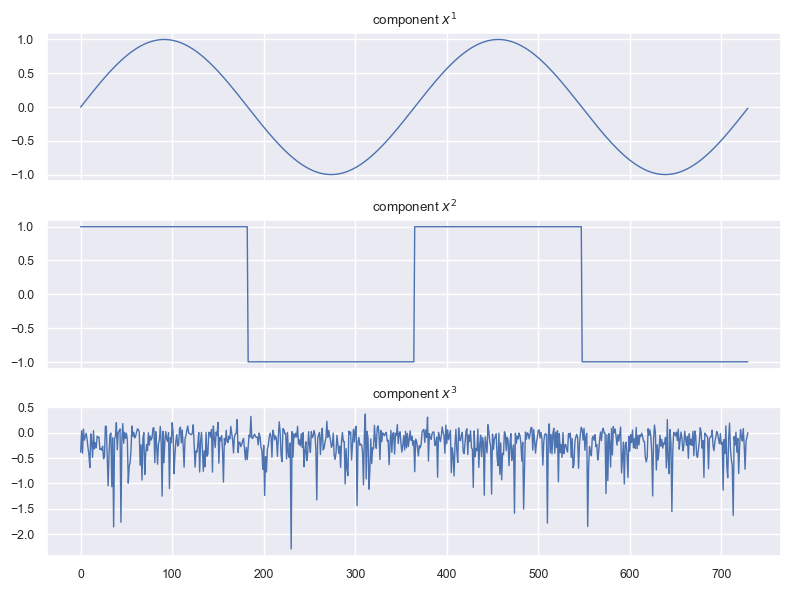

In [3]:
t = np.arange(365*2)

# seasonal term
signal1 = np.sin(2 * np.pi * t * 1 / (365.))
# piecewise constant term
signal2 = signal.square(2 * np.pi * t * 1 / (365.))
# asymmetric laplace noise 
kappa = 2 # k>0, k=1 is laplace
signal3 = 0.15 * laplace_asymmetric.rvs(kappa, size=len(signal1))

X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = signal1
X_real[1] = signal2
X_real[2] = signal3
y = np.sum(X_real, axis=0)

plot_decomp(X_real)

In [4]:
indices_full = list(range(len(X_real[1])))
# select 20% randomly
indices_20perc = np.random.choice(indices_full, 200, replace=False)

X_real_80perc = X_real.copy()
y_80perc = y.copy()

X_real_80perc[0][indices_20perc] = np.nan
X_real_80perc[1][indices_20perc] = np.nan
y_80perc[indices_20perc] = np.nan

In [5]:
indices_chunks_start = np.random.choice(indices_full, 5, replace=False)
X_real_chunks= X_real.copy()
y_chunks = y.copy()

for e in indices_chunks_start:
    for i in range(e, e+25):
        X_real_chunks[0][i] = np.nan
        X_real_chunks[1][i] = np.nan
        y_chunks[i] = np.nan

# MOSEK+LinearTerm/MOSEK

CVXPY objective       119.43725
OSD objective, scaled 118.59956
s_hat MAE (OSD,CVX)   4.64e-02
s_seas MAE (OSD,CVX)   4.85e-02


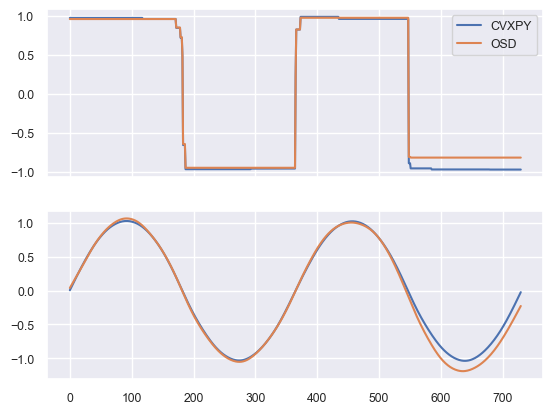

In [6]:
s_hat_cvxpy_mosek, s_seas_cvxpy_mosek = cvx_sd(y, tau=0.8, c1=5, c2=1e5, c3=1e2, linear_term=True, solver="MOSEK")
s_hat_osd_mosek, s_seas_osd_mosek = osd_sd(y, tau=0.8, w1=5, w2=1e5, w3=1e2, linear_term=True, solver="MOSEK")

obj_osd_scaled = cvx_sd(y, tau=0.8, c1=5, c2=1e5, c3=1e2, linear_term=True, comp_osd=[s_hat_osd_mosek, s_seas_osd_mosek]) 
print(f's_hat MAE (OSD,CVX)   {mae(s_hat_cvxpy_mosek, s_hat_osd_mosek):.2e}')
print(f's_seas MAE (OSD,CVX)   {mae(s_seas_cvxpy_mosek, s_seas_osd_mosek):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(s_hat_cvxpy_mosek, label="CVXPY")
ax1.plot(s_hat_osd_mosek, label="OSD")
ax2.plot(s_seas_cvxpy_mosek)
ax2.plot(s_seas_osd_mosek)
ax1.legend()
plt.show()

# MOSEK/QSS

CVXPY objective       119.43725
OSD objective, scaled 118.60116
s_hat MAE (OSD,CVX)   6.76e-02
s_seas MAE (OSD,CVX)   4.85e-02


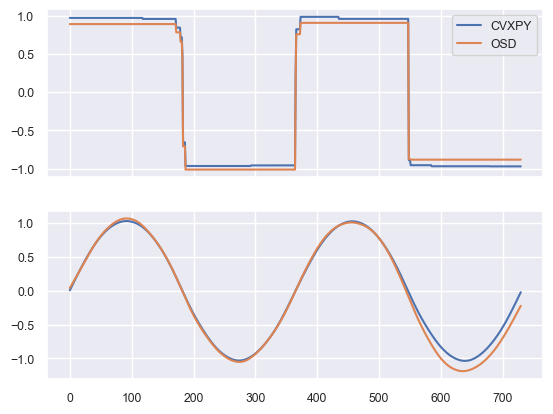

In [6]:
s_hat_cvxpy_mosek, s_seas_cvxpy_mosek = cvx_sd(y, tau=0.8, c1=5, c2=1e5, c3=1e2, linear_term=True, solver="MOSEK")
s_hat_osd_mosek, s_seas_osd_mosek = osd_sd(y, tau=0.8, w1=5, w2=1e5, w3=1e2, linear_term=True, solver="QSS")

obj_osd_scaled = cvx_sd(y, tau=0.8, c1=5, c2=1e5, c3=1e2, linear_term=True, comp_osd=[s_hat_osd_mosek, s_seas_osd_mosek]) 
print(f's_hat MAE (OSD,CVX)   {mae(s_hat_cvxpy_mosek, s_hat_osd_mosek):.2e}')
print(f's_seas MAE (OSD,CVX)   {mae(s_seas_cvxpy_mosek, s_seas_osd_mosek):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(s_hat_cvxpy_mosek, label="CVXPY")
ax1.plot(s_hat_osd_mosek, label="OSD")
ax2.plot(s_seas_cvxpy_mosek)
ax2.plot(s_seas_osd_mosek)
ax1.legend()
plt.show()

without linear term

CVXPY objective       118.85334
OSD objective, scaled 118.85334
s_hat MAE (OSD,CVX)   1.88e-10
s_seas MAE (OSD,CVX)   2.19e-10


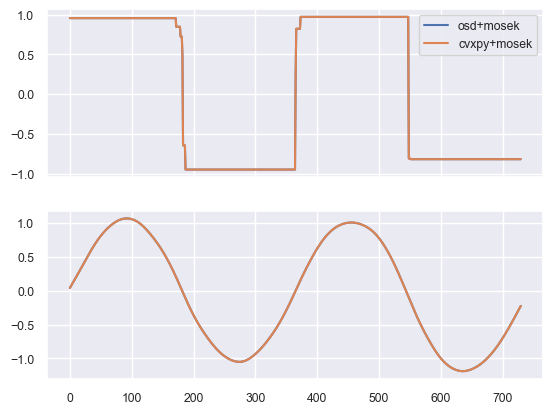

In [9]:
w_osd = { 'w1' : 5,
          'w2' : 1e5,
          #'w3' : 1e2
          }
w_cvx = { 'c1' : 5,
          'c2' : 1e5,
          #'c3' : 1e2
          }

osd_output = osd_sd(y, tau=0.8, **w_osd, solver="MOSEK", linear_term=False)
cvxpy_output = cvx_sd(y, tau=0.8, **w_cvx, solver="MOSEK", linear_term=False, comp_osd=osd_output) # for osd scaling

cvxpy_output = cvx_sd(y, tau=0.8, **w_cvx, linear_term=False, solver="MOSEK")

print(f's_hat MAE (OSD,CVX)   {mae(osd_output[0], cvxpy_output[0]):.2e}')
print(f's_seas MAE (OSD,CVX)   {mae(osd_output[1], cvxpy_output[1]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(osd_output[0], label="osd+mosek")
ax1.plot(cvxpy_output[0], label="cvxpy+mosek")
#ax1.plot(X_real[1], label="True")
ax2.plot(osd_output[1], label="osd+mosek")
ax2.plot(cvxpy_output[1], label="cvxpy+mosek")
#ax2.plot(X_real[0], label="True")
ax1.legend();

with linear term

CVXPY objective       119.37732
OSD objective, scaled 118.59797
s_hat MAE (OSD,CVX)   1.05e-03
s_seas MAE (OSD,CVX)   4.10e-04


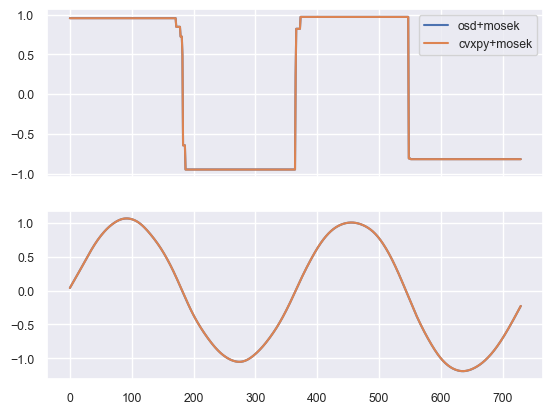

In [10]:
w_osd = { 'w1' : 5,
          'w2' : 1e5,
          #'w3' : 1e2
          }
w_cvx = { 'c1' : 5,
          'c2' : 1e5,
          #'c3' : 1e2
          }

osd_output = osd_sd(y, tau=0.8, **w_osd, solver="MOSEK", linear_term=True)
cvxpy_output = cvx_sd(y, tau=0.8, **w_cvx, solver="MOSEK", linear_term=True, comp_osd=osd_output) # for osd scaling

cvxpy_output = cvx_sd(y, tau=0.8, **w_cvx, linear_term=False, solver="MOSEK")

print(f's_hat MAE (OSD,CVX)   {mae(osd_output[0], cvxpy_output[0]):.2e}')
print(f's_seas MAE (OSD,CVX)   {mae(osd_output[1], cvxpy_output[1]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(osd_output[0], label="osd+mosek")
ax1.plot(cvxpy_output[0], label="cvxpy+mosek")
#ax1.plot(X_real[1], label="True")
ax2.plot(osd_output[1], label="osd+mosek")
ax2.plot(cvxpy_output[1], label="cvxpy+mosek")
#ax2.plot(X_real[0], label="True")
ax1.legend();

with QSS + linear term

CVXPY objective       134.62617
OSD objective, scaled 133.41056
s_hat MAE (OSD,CVX)   5.63e-03
s_seas MAE (OSD,CVX)   4.28e-03


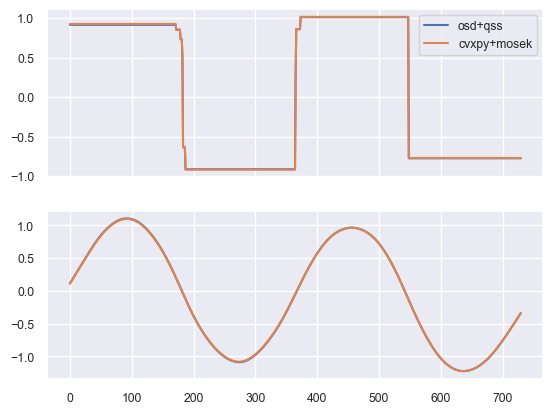

In [8]:
w_osd = { 'w1' : 7,
          'w2' : 2e5,
          #'w3' : 1e2
          }
w_cvx = { 'c1' : 7,
          'c2' : 2e5,
          #'c3' : 1e2
          }

osd_output = osd_sd(y, tau=0.8, **w_osd, solver="QSS", linear_term=True)
cvxpy_output = cvx_sd(y, tau=0.8, **w_cvx, solver="MOSEK", linear_term=True, comp_osd=osd_output) # for osd scaling

cvxpy_output = cvx_sd(y, tau=0.8, **w_cvx, linear_term=False, solver="MOSEK")

print(f's_hat MAE (OSD,CVX)   {mae(osd_output[0], cvxpy_output[0]):.2e}')
print(f's_seas MAE (OSD,CVX)   {mae(osd_output[1], cvxpy_output[1]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(osd_output[0], label="osd+qss")
ax1.plot(cvxpy_output[0], label="cvxpy+mosek")
#ax1.plot(X_real[1], label="True")
ax2.plot(osd_output[1], label="osd+qss")
ax2.plot(cvxpy_output[1], label="cvxpy+mosek")
#ax2.plot(X_real[0], label="True")
ax1.legend();

# with SumCard

## w/o linear term

In [37]:
from gfosd import Problem
import gfosd.components as comp

c1 = comp.SumQuantile(tau=0.8, weight=1/(len(y)-1))
c2 = comp.SumCard(weight=1/(len(y)-1), diff=1)
c3 = comp.Aggregate([
    comp.SumSquare(weight=1e2, diff=2),
    comp.AverageEqual(0, period=365)
])
foo = Problem(y, [c1, c2, c3])
foo.decompose(verbose=True)

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      3.28e-03s
(nonconvex warm-start algorithm)

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 5.69e-01    1.61e+00     3.21e-01   [0.1 0.1 0.1]  6.81e-04
   25 | 2.08e-01    9.20e-03     1.12e-03   [0.1 0.1 0.1]  1.33e-02
   50 | 1.42e-01    1.45e-02     2.74e-02   [1.e-01 1.e-01 1.e-06]  2.87e-02
   75 | 9.51e-02    7.65e-03     7.93e-04   [1.e-01 1.e-01 1.e-06]  4.21e-02
  100 | 8.04e-02    3.22e-03     4.70e-04   [1.e-01 1.e-01 1.e-06]  5.58e-02
  125 | 7.35e-02    2.98e-03     3.53e-04   

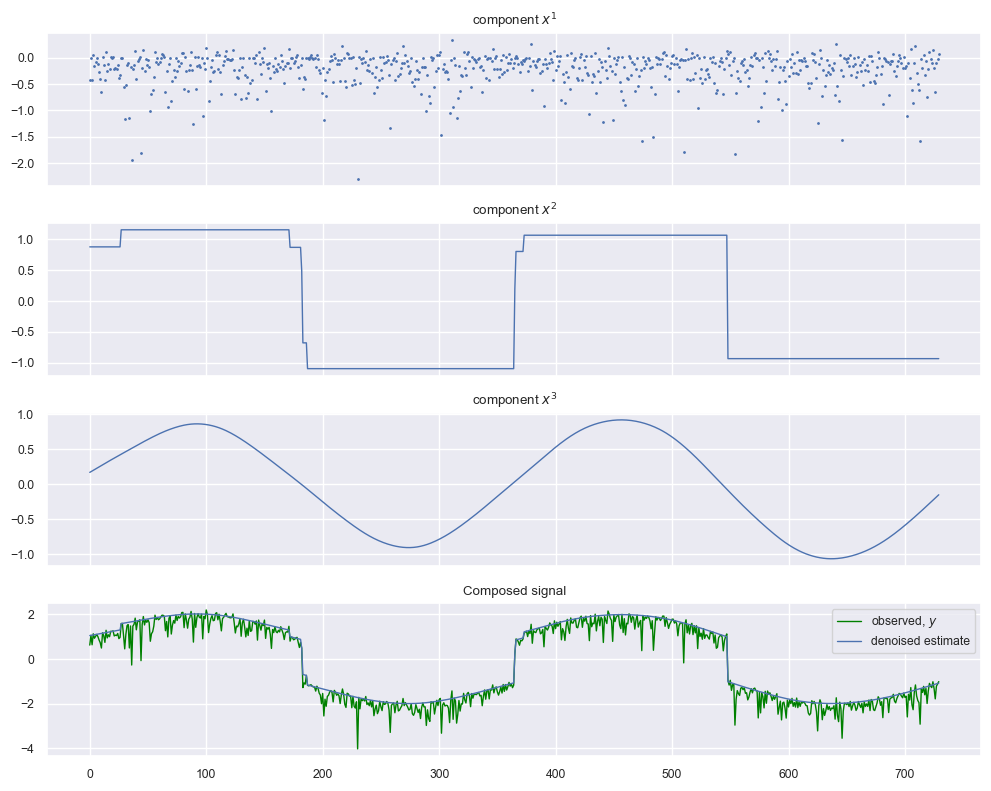

In [27]:
foo.plot_decomposition();

CVXPY objective       118.85334
OSD objective, scaled 121.06535
s_hat MAE (OSD,CVX)   9.30e-02
s_seas MAE (OSD,CVX)   8.94e-02


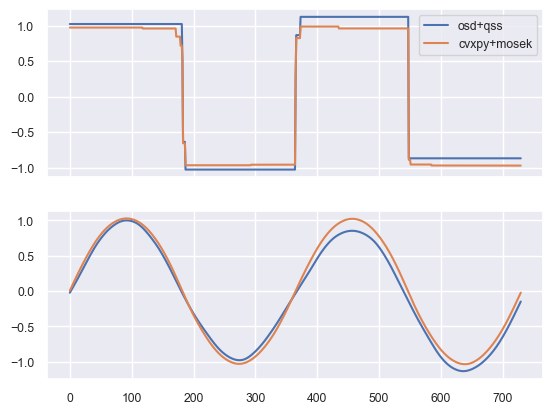

In [39]:
w_osd = { 'w1' : 1/(len(y)-1), # sumcard 
          'w2' : 50,
          #'w3' : 1e2 # linear term
          'w4' : 1/(len(y)-1) # tl1 term
          }
w_cvx = { 'c1' : 5,
          'c2' : 1e5,
          #'c3' : 1e2
          }

osd_output = osd_sd(y, tau=0.8, **w_osd, solver="QSS", linear_term=False, sum_card=True)
cvxpy_output = cvx_sd(y, tau=0.8, **w_cvx, solver="MOSEK", linear_term=False, comp_osd=osd_output) # for osd scaling

cvxpy_output = cvx_sd(y, tau=0.8, **w_cvx, linear_term=True, solver="MOSEK")

print(f's_hat MAE (OSD,CVX)   {mae(osd_output[0], cvxpy_output[0]):.2e}')
print(f's_seas MAE (OSD,CVX)   {mae(osd_output[1], cvxpy_output[1]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(osd_output[0], label="osd+qss")
ax1.plot(cvxpy_output[0], label="cvxpy+mosek")
#ax1.plot(X_real[1], label="True")
ax2.plot(osd_output[1], label="osd+qss")
ax2.plot(cvxpy_output[1], label="cvxpy+mosek")
#ax2.plot(X_real[0], label="True")
ax1.legend();

## reweighting

In [61]:
np.log10(50)

1.6989700043360187

In [62]:
results = {}
weight_iter = np.logspace(1.7, 2.2, 50)

def run(sig):
    mae_s_hat_list = []
    for w in tqdm(weight_iter):
        s_hat = osd_sd(sig, tau=0.8, w2=w, w1=(len(y)-1), w4=(len(y)-1), solver="QSS", linear_term=False, sum_card=True)[0]
        mae_s_hat_list.append(mae(X_real[1], s_hat))
        
    results["weight_min"] =  weight_iter[np.argmin(mae_s_hat_list)]
    results["mae_min"] = np.min(mae_s_hat_list)
    results["mae_s_hat_list"] = mae_s_hat_list

In [63]:
run(y)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [06:43<00:00,  8.06s/it]


In [65]:
print(results["weight_min"])

128.28127427142124


CVXPY objective       118.85334
OSD objective, scaled 122.89134
s_hat MAE (OSD,CVX)   9.83e-02
s_seas MAE (OSD,CVX)   9.22e-02


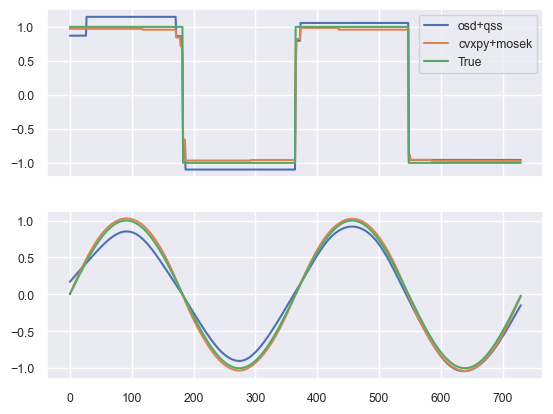

In [77]:
w_osd = { 'w1' : 1/(len(y)-1), # sumcard 
          'w2' : results["weight_min"],
          #'w3' : 1e2 # linear term
          'w4' :  1/(len(y)-1) # tl1 term
          }
w_cvx = { 'c1' : 5,
          'c2' : 1e5,
          }

osd_output = osd_sd(y, tau=0.8, **w_osd, solver="QSS", linear_term=False, sum_card=True)
cvxpy_output = cvx_sd(y, tau=0.8, **w_cvx, solver="MOSEK", linear_term=False, comp_osd=osd_output) # for osd scaling

cvxpy_output = cvx_sd(y, tau=0.8, **w_cvx, linear_term=True, solver="MOSEK")

print(f's_hat MAE (OSD,CVX)   {mae(osd_output[0], cvxpy_output[0]):.2e}')
print(f's_seas MAE (OSD,CVX)   {mae(osd_output[1], cvxpy_output[1]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(osd_output[0], label="osd+qss")
ax1.plot(cvxpy_output[0], label="cvxpy+mosek")
ax1.plot(X_real[1], label="True")
ax2.plot(osd_output[1], label="osd+qss")
ax2.plot(cvxpy_output[1], label="cvxpy+mosek")
ax2.plot(X_real[0], label="True")
ax1.legend();

CVXPY objective       118.85334
OSD objective, scaled 120.75230
s_hat MAE (OSD,CVX)   6.92e-02
s_seas MAE (OSD,CVX)   6.24e-02


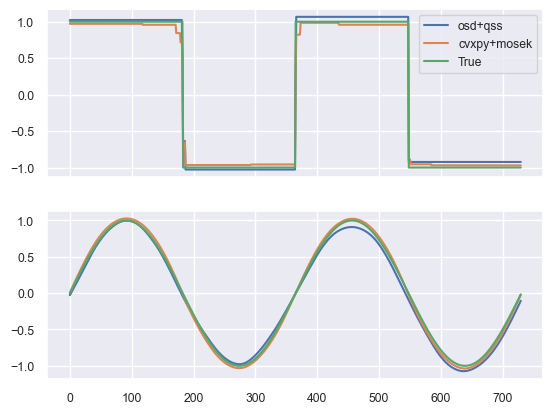

In [73]:
w_osd = { 'w1' : 0.003, # sumcard 
          'w2' : results["weight_min"],
          #'w3' : 1e2 # linear term
          'w4' : 0.003 # tl1 term
          }
w_cvx = { 'c1' : 5,
          'c2' : 1e5,
          }

osd_output = osd_sd(y, tau=0.8, **w_osd, solver="QSS", linear_term=False, sum_card=True)
cvxpy_output = cvx_sd(y, tau=0.8, **w_cvx, solver="MOSEK", linear_term=False, comp_osd=osd_output) # for osd scaling

cvxpy_output = cvx_sd(y, tau=0.8, **w_cvx, linear_term=True, solver="MOSEK")

print(f's_hat MAE (OSD,CVX)   {mae(osd_output[0], cvxpy_output[0]):.2e}')
print(f's_seas MAE (OSD,CVX)   {mae(osd_output[1], cvxpy_output[1]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(osd_output[0], label="osd+qss")
ax1.plot(cvxpy_output[0], label="cvxpy+mosek")
ax1.plot(X_real[1], label="True")
ax2.plot(osd_output[1], label="osd+qss")
ax2.plot(cvxpy_output[1], label="cvxpy+mosek")
ax2.plot(X_real[0], label="True")
ax1.legend();

## w/ linear term

In [85]:
results = {}
weight_iter = np.logspace(1, 2.5, 50)

def run(sig):
    mae_s_hat_list = []
    for w in tqdm(weight_iter):
        s_hat = osd_sd(sig, tau=0.8, w2=w, w1=(len(y)-1), w4=(len(y)-1), solver="QSS", linear_term=True, sum_card=True)[0]
        mae_s_hat_list.append(mae(X_real[1], s_hat))
        
    results["weight_min_lin"] =  weight_iter[np.argmin(mae_s_hat_list)]
    results["mae_min_lin"] = np.min(mae_s_hat_list)
    results["mae_s_hat_list_lin"] = mae_s_hat_list

In [86]:
run(y)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:25<00:00,  6.51s/it]


In [87]:
print(results["weight_min_lin"])

54.286754393238596


CVXPY objective       119.37732
OSD objective, scaled 120.78226
s_hat MAE (OSD,CVX)   7.86e-02
s_seas MAE (OSD,CVX)   9.05e-02


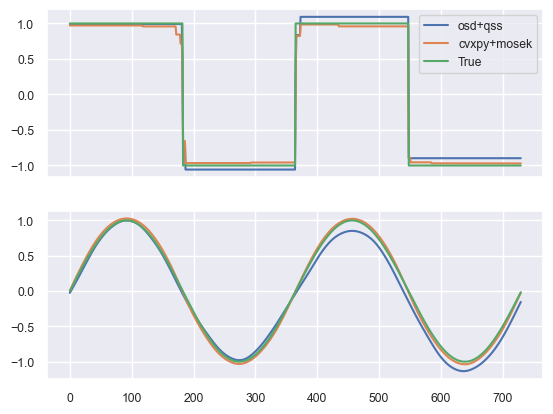

In [89]:
w_osd = { 'w1' : 1/(len(y)-1), # sumcard 
          'w2' : results["weight_min_lin"],
       #   'w3' : 1/(len(y)-2), # linear term
          'w4' : 1/(len(y)-1) # tl1 term
          }
w_cvx = { 'c1' : 5,
          'c2' : 1e5,
          }

osd_output = osd_sd(y, tau=0.8, **w_osd, solver="QSS", linear_term=True, sum_card=True)
cvxpy_output = cvx_sd(y, tau=0.8, **w_cvx, solver="MOSEK", linear_term=True, comp_osd=osd_output) # for osd scaling

cvxpy_output = cvx_sd(y, tau=0.8, **w_cvx, linear_term=True, solver="MOSEK")

print(f's_hat MAE (OSD,CVX)   {mae(osd_output[0], cvxpy_output[0]):.2e}')
print(f's_seas MAE (OSD,CVX)   {mae(osd_output[1], cvxpy_output[1]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(osd_output[0], label="osd+qss")
ax1.plot(cvxpy_output[0], label="cvxpy+mosek")
ax1.plot(X_real[1], label="True")
ax2.plot(osd_output[1], label="osd+qss")
ax2.plot(cvxpy_output[1], label="cvxpy+mosek")
ax2.plot(X_real[0], label="True")
ax1.legend();